In [31]:
# Import libraries
import pandas as pd
from gensim.models import KeyedVectors
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import nltk
import random
from collections import Counter
import itertools
import numpy as np
from keras.models import Sequential, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras import callbacks
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [32]:
# Download data for nltk model (Only need to do once)
# nltk.download('book')

In [33]:
# Keep reproducible results (Remove randomness between runs)
import tensorflow as tf
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [34]:
# Load data
train = pd.read_csv('data/labeledTrainData.tsv', header=0, 
 delimiter="\t", quoting=3)
test = pd.read_csv('data/testData.tsv', header=0, delimiter="\t", quoting=3)

In [35]:
# Split Train and Validation Data
VALIDATION_SPLIT = 0.1
train_len = int(len(train)*(1-VALIDATION_SPLIT))
train_train = train.iloc[:train_len]
train_val = train.iloc[train_len:]

In [36]:
# Tokenize training data
def review_tokenized(review, remove_stopwords=False):
    review_text = BeautifulSoup(review, 'lxml').get_text()
    if len(review_text) >= 2 and review_text[0] == '"' and review_text[-1] == '"': # Remove openning and closing quotes
        review_text = review_text[1:-1]
    review_tokens = nltk.word_tokenize(review_text.lower())
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        review_tokens = [t for t in review_tokens if not t in stops]
    return review_tokens

def tokenFreqDist(token_list):
    return nltk.FreqDist(itertools.chain(*token_list))

def review_list_tokenized(reviews, remove_stopwords=False):
    review_tokens = []
    for i, r in zip(range(1, len(reviews)+1), reviews):
        review_tokens.append(review_tokenized(r, remove_stopwords=remove_stopwords))
        if i%2000 == 0:
            print('processed {} reviews.'.format(i))
    return review_tokens
X_tokens_train = review_list_tokenized(train_train['review']) # list of tokenized reviews

processed 2000 reviews.
processed 4000 reviews.
processed 6000 reviews.
processed 8000 reviews.
processed 10000 reviews.
processed 12000 reviews.
processed 14000 reviews.
processed 16000 reviews.
processed 18000 reviews.
processed 20000 reviews.
processed 22000 reviews.


In [37]:
# Build token dicts (for vectorization)
print('getting frequency distribution.')
token_dist = tokenFreqDist(X_tokens_train) # token dict with freq as value
print('Done.')
vocab_size = 10000 
vocab = token_dist.most_common(vocab_size-2)
UNKNOWN_TOKEN = 'UNKNOWN_TOKEN'
PADDING = 'PADDING'
def create_token_dicts(vocab):
    index_to_token = [x[0] for x in vocab]
    index_to_token.append(UNKNOWN_TOKEN)
    index_to_token.append(PADDING)
    token_to_index = {x:i for i, x in enumerate(index_to_token)}
    return (index_to_token, token_to_index)
index_to_token, token_to_index = create_token_dicts(vocab)

getting frequency distribution.
Done.


In [38]:
# Substitue words not in vocab by UNKNOWN_TOKEN
def prune_tokens(review_tokens):
    tokens_pruned = []
    for token in review_tokens:
        tokens_pruned.append([w if w in token_to_index else UNKNOWN_TOKEN for w in token])
    return tokens_pruned
X_tokens_pruned_train = prune_tokens(X_tokens_train)

In [39]:
# Prepare final training data
def vectorize_sentences(review_token):
    # Returns a vector that represents a review
    return np.asarray([token_to_index[x] for x in review_token])

def vectorize_reviews(reviews_tokens):
    # Returns a list of vectors where each number in the vector represents a word in the review
    return [vectorize_sentences(s) for s in reviews_tokens]

X_train = vectorize_reviews(X_tokens_pruned_train)

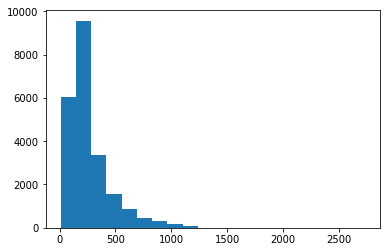

In [40]:
# Plot a histogram of X_train sentence lengths to decide the length of reviews (for truncating and padding)
lengths = list(map(lambda x: len(x), X_train))
fig = plt.figure()
_ = plt.hist(lengths, bins=20)

In [41]:
# Seems like a size of 300 will capture most of reviews in entirety
MAX_REVIEW_SIZE = 300
X_train = pad_sequences(X_train, maxlen=MAX_REVIEW_SIZE, value=token_to_index[PADDING], padding='pre', truncating='post')
y_train = train_train['sentiment'].values.reshape(-1, 1)

In [42]:
print(X_train.shape)
print(y_train.shape)

(22500, 300)
(22500, 1)


In [43]:
# Prepare validation data
def process_X(reviews):
    X = review_list_tokenized(reviews)
    X = prune_tokens(X)
    X = vectorize_reviews(X)
    X = pad_sequences(X, maxlen=MAX_REVIEW_SIZE, value=token_to_index[PADDING], padding='pre', truncating='post')
    return X
X_val = process_X(train_val['review'])
y_val = train_val['sentiment'].values.reshape(-1, 1)

processed 2000 reviews.


In [46]:
# Build RNN model for sentiment analysis
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=16, input_length=X_train.shape[1]))
model.add(LSTM(4, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='RMSProp', metrics=['accuracy'])
# Add checkpoint to save the 'best' model
fname = 'model/imdb_sentiment_analysis.h5'
cbks = [callbacks.ModelCheckpoint(filepath=fname, monitor='val_loss', save_best_only=True)]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 16)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
dropout_3 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                80        
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [47]:
import time
start = time.time()
history = model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1, 
                    shuffle=True, validation_data=(X_val, y_val), callbacks=cbks)
end = time.time()
print('Takes {}s'.format(end-start))

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 119s - loss: 0.5883 - acc: 0.7250 - val_loss: 0.3881 - val_acc: 0.8460
Epoch 2/5
22500/22500 [==============================] - 119s - loss: 0.3644 - acc: 0.8652 - val_loss: 0.3315 - val_acc: 0.8696
Epoch 3/5
22500/22500 [==============================] - 119s - loss: 0.3002 - acc: 0.8941 - val_loss: 0.3423 - val_acc: 0.8640
Epoch 4/5
22500/22500 [==============================] - 118s - loss: 0.2649 - acc: 0.9081 - val_loss: 0.3137 - val_acc: 0.8740
Epoch 5/5
22500/22500 [==============================] - 119s - loss: 0.2448 - acc: 0.9174 - val_loss: 0.3817 - val_acc: 0.8644
Takes 599.3994255065918s


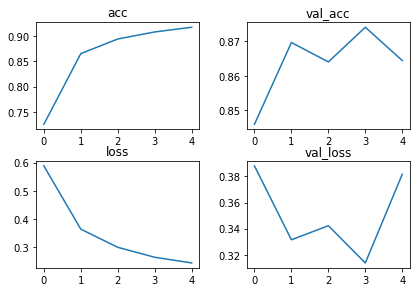

In [48]:
# Plot trends for insights
def plot_history(history):
    history_data = history.history
    fig, axes = plt.subplots(2, 2)
    fig.tight_layout()
    for i, key in enumerate(history_data.keys()):
        ax = plt.subplot(2, 2, i+1)
        plt.plot(history_data[key])
        ax.set_title(key)
plot_history(history)

In [57]:
# Compute Area under ROC score
predictions = model.predict_classes(X_val)
print(roc_auc_score(y_val, predictions))

2500/2500 [==============================] - 1s     
0.878707877969


In [58]:
histories = []
histories.append(history)

In [59]:
# Train for longer
history = model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1, 
                    shuffle=True, validation_data=(X_val, y_val), callbacks=cbks)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 119s - loss: 0.2252 - acc: 0.9252 - val_loss: 0.3522 - val_acc: 0.8604
Epoch 2/5
22500/22500 [==============================] - 118s - loss: 0.2177 - acc: 0.9265 - val_loss: 0.6044 - val_acc: 0.8108
Epoch 3/5
22500/22500 [==============================] - 119s - loss: 0.2080 - acc: 0.9307 - val_loss: 0.3194 - val_acc: 0.8824
Epoch 4/5
22500/22500 [==============================] - 118s - loss: 0.2060 - acc: 0.9323 - val_loss: 0.3099 - val_acc: 0.8800
Epoch 5/5
22500/22500 [==============================] - 118s - loss: 0.1986 - acc: 0.9366 - val_loss: 0.3387 - val_acc: 0.8800


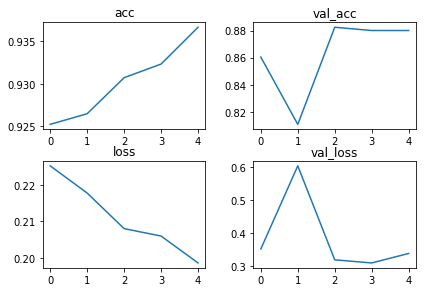

In [60]:
plot_history(history)
histories.append(history)

In [61]:
# Training longer seems not to do more good, so let's stop here
# To further squeeze performance, could try to increase MAX_REVIEW_SIZE to cover them

In [62]:
# Load best model so far check with validation
fname = 'model/imdb_sentiment_analysis.h5'
model = load_model(fname)
print(model.evaluate(X_val, y_val))
# Compute Area under ROC score
preds = model.predict_classes(X_val)
print(roc_auc_score(y_val, preds))

2500/2500 [==============================] - 2s     
0.880019251397


In [66]:
# Make predictions and save them
X_test = process_X(test['review'])
preds = model.predict_classes(X_test, verbose=1)
pd.DataFrame({
    'id': test['id'].str.replace('"', ''),
    'sentiment': preds.reshape(-1,)}).to_csv('submission.csv', index=False, header=True)

processed 2000 reviews.
processed 4000 reviews.
processed 6000 reviews.
processed 8000 reviews.
processed 10000 reviews.
processed 12000 reviews.
processed 14000 reviews.
processed 16000 reviews.
processed 18000 reviews.
processed 20000 reviews.
processed 22000 reviews.
processed 24000 reviews.
24960/25000 [============================>.] - ETA: 0s

In [68]:
# Check output
submission = pd.read_csv('submission.csv')
submission.head(5)

,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


In [8]:
# Collect unused memory
import gc; gc.collect()

6744

### Training seems to be overfitting; Try word2vec
From below we will use pretrained word2vec instead of the custom embedding layer, and see how it goes.

In [9]:
# Load Word2Vec
word2vec = KeyedVectors.load_word2vec_format('word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [11]:
# Check
print(word2vec.wv.most_similar('king'))
print(word2vec.wv.word_vec('king').shape)

[('kings', 0.7138046026229858), ('queen', 0.6510956883430481), ('monarch', 0.6413194537162781), ('crown_prince', 0.6204220056533813), ('prince', 0.6159993410110474), ('sultan', 0.5864822864532471), ('ruler', 0.5797567367553711), ('princes', 0.5646552443504333), ('Prince_Paras', 0.543294370174408), ('throne', 0.5422104597091675)]
(300,)


In [12]:
# Find how many words in our vocab are not included in word2vec
not_included = set()
for word in vocab:
    if word[0] not in word2vec.wv.vocab:
        not_included.add(word)
print('#Words in our original vocab, but not in word2vec: {}'.format(len(not_included)))

#Words in our original vocab, but not in word2vec: 909


In [10]:
# Remove words that are not word2vec from vocab
vocab_reduced = []
for word in vocab:
    if word[0] in word2vec.wv.vocab:
        vocab_reduced.append(word)

In [14]:
# Sampling kept words to get an idea of its content
random.sample(vocab_reduced, 2)

[('slapped', 43), ("'re", 3377)]

In [11]:
WORD2VEC_LEN = 300
def convert_word_to_vec(word):
    if word in word2vec.wv:
        return word2vec.wv[word]
    else:
        return np.zeros((WORD2VEC_LEN,))
    
def convert_review_tokens_to_matrices(review_tokens):
    review_vecs = []
    for i, r in zip(range(1, len(review_tokens)+1), review_tokens):
        vec = np.asarray([convert_word_to_vec(w) for w in r])
        assert vec.shape[1] == WORD2VEC_LEN
        review_vecs.append(vec)
        if i%5000 == 0:
            print('processed {} reviews'.format(i))
    return review_vecs
    
X_tokens_matrices_train = convert_review_tokens_to_matrices(X_tokens_train)

processed 5000 reviews
processed 10000 reviews
processed 15000 reviews
processed 20000 reviews


In [12]:
# Collect unused memory
import gc; gc.collect()

302

In [13]:
# Convert from a list of matrices to 3-dim matrices by padding and truncating (in order to feed in to RNN)
MAX_REVIEW_SIZE = 300
def truncate_and_pad(review_matrices, length):
    for i, matrix in enumerate(review_matrices):
        matrix = matrix[:length]
        if len(matrix) < length:
            height = length-matrix.shape[0]
            width = matrix.shape[1]
            matrix = np.concatenate((matrix, np.zeros((height, width))), axis=0)
            assert matrix.shape == (length, WORD2VEC_LEN)
        review_matrices[i] = matrix
        if i%5000 == 0:
            print('processed {} reviews'.format(i))
    review_matrices = np.asarray(review_matrices)
    assert review_matrices[0].shape == (length, WORD2VEC_LEN)
    return review_matrices
X_train = truncate_and_pad(X_tokens_matrices_train, length=MAX_REVIEW_SIZE)

processed 0 reviews
processed 5000 reviews
processed 10000 reviews
processed 15000 reviews
processed 20000 reviews


In [14]:
print(X_train.shape)

(22500, 300, 300)


#### Notes on training data size
* Training data takes a huge amount of memory. (barely fits in a 52GB memory machine)
* Could try to load training data in batches if it does not fit into memory in entirety.

In [15]:
# Prepare Validation data
X_tokens_val = review_list_tokenized(train_val['review'])
X_val = convert_review_tokens_to_matrices(X_tokens_val)
X_val = truncate_and_pad(X_val, length=MAX_REVIEW_SIZE)

processed 2000 reviews.
processed 0 reviews


In [23]:
print(X_train.shape)

(11250, 300, 300)


In [16]:
# Check conversion by word2vec success
def check_word2vec(X, tokens):
    i = random.randint(0, len(tokens)-1)
    j = random.randint(0, len(tokens[i])-1)
    j = min(j, MAX_REVIEW_SIZE)
    token = tokens[i][j]
    if token in word2vec.wv:
        compare = word2vec.wv[token]
    else:
        compare = np.zeros((WORD2VEC_LEN,))
    diff = X[i][j] - compare
    assert np.linalg.norm(diff) < 0.001
check_word2vec(X_train, X_tokens_train)
check_word2vec(X_val, X_tokens_val)
# diff = X_val[2][0] - word2vec.wv[val_tokens[2][0]]
# assert np.linalg.norm(diff) < 0.001

In [17]:
# Prepare y data for train and validation
y_train = train_train['sentiment'].values.reshape(-1, 1)
y_val = train_val['sentiment'].values.reshape(-1, 1)

In [18]:
# Build RNN model for sentiment analysis
model = Sequential()
model.add(LSTM(16, return_sequences=False, kernel_regularizer=l2(0.01), input_shape=(MAX_REVIEW_SIZE, WORD2VEC_LEN)))
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='RMSProp', metrics=['accuracy'])
fname = 'model/imdb_sentiment_analysis_word2vec.h5'
cbks = [callbacks.ModelCheckpoint(filepath=fname, monitor='val_loss', save_best_only=True)]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                20288     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 20,577
Trainable params: 20,577
Non-trainable params: 0
_________________________________________________________________


In [19]:
import time
start = time.time()
history = model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1,
                    shuffle=True, validation_data=(X_val, y_val), callbacks=cbks)
end = time.time()
print('Takes {}s'.format(end-start))

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 217s - loss: 0.7357 - acc: 0.5283 - val_loss: 0.6724 - val_acc: 0.6296
Epoch 2/5
22500/22500 [==============================] - 214s - loss: 0.6574 - acc: 0.6531 - val_loss: 0.6273 - val_acc: 0.6708
Epoch 3/5
22500/22500 [==============================] - 213s - loss: 0.6248 - acc: 0.7120 - val_loss: 0.7882 - val_acc: 0.6308
Epoch 4/5
22500/22500 [==============================] - 213s - loss: 0.6253 - acc: 0.7234 - val_loss: 0.7352 - val_acc: 0.6892
Epoch 5/5
22500/22500 [==============================] - 212s - loss: 0.6170 - acc: 0.7309 - val_loss: 0.5170 - val_acc: 0.8080
Takes 1072.6834962368011s


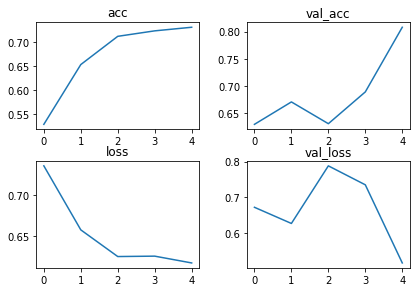

In [21]:
# Plot trends for insights
plot_history(history)
histories = []
histories.append(history)

In [22]:
# Train for longer and see how it goes
history = model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1, 
                    shuffle=True, validation_data=(X_val, y_val), callbacks=cbks)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 214s - loss: 0.5703 - acc: 0.7654 - val_loss: 0.8669 - val_acc: 0.6592
Epoch 2/5
22500/22500 [==============================] - 215s - loss: 0.5660 - acc: 0.7556 - val_loss: 0.8346 - val_acc: 0.5632
Epoch 3/5
22500/22500 [==============================] - 216s - loss: 0.5830 - acc: 0.7544 - val_loss: 0.6304 - val_acc: 0.7084
Epoch 4/5
22500/22500 [==============================] - 216s - loss: 0.5741 - acc: 0.7647 - val_loss: 0.5771 - val_acc: 0.7772
Epoch 5/5
22500/22500 [==============================] - 216s - loss: 0.5932 - acc: 0.7527 - val_loss: 0.5209 - val_acc: 0.7912


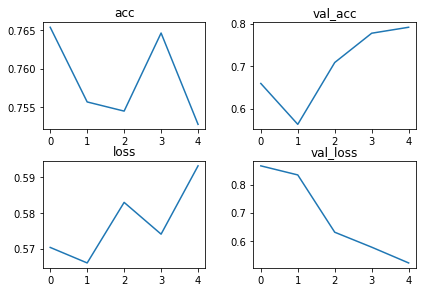

In [23]:
plot_history(history)
histories.append(history)

In [24]:
# Train for longer and see how it goes
history = model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1, 
                    shuffle=True, validation_data=(X_val, y_val), callbacks=cbks)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 217s - loss: 0.5713 - acc: 0.7696 - val_loss: 0.6757 - val_acc: 0.6692
Epoch 2/5
22500/22500 [==============================] - 216s - loss: 0.5927 - acc: 0.7412 - val_loss: 0.5196 - val_acc: 0.7840
Epoch 3/5
22500/22500 [==============================] - 225s - loss: 0.5763 - acc: 0.7548 - val_loss: 0.5952 - val_acc: 0.7456
Epoch 4/5
22500/22500 [==============================] - 242s - loss: 0.6050 - acc: 0.7404 - val_loss: 0.6436 - val_acc: 0.7156
Epoch 5/5
22500/22500 [==============================] - 240s - loss: 0.6161 - acc: 0.7211 - val_loss: 0.5111 - val_acc: 0.7860


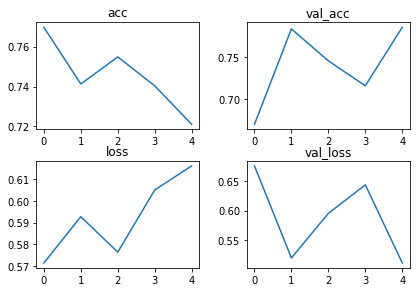

In [27]:
plot_history(history)
histories.append(history)

#### Notes on using word2vec embedding
* The result of using word2vec as word embedding seems to be flunctuating and not working well (yet).
* I think the reason may be that the vector dim of 300 might be too large while the training set is too small to generalize it well.